In [56]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.7/dist-packages (1.0.2)


In [57]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from glob import glob
import matplotlib.pyplot as plt


In [58]:
print(tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

2.5.0
Default GPU Device: /device:GPU:0


In [59]:
train_datagenerator = ImageDataGenerator(rescale = 1.0/255,
                                        shear_range = 0.2,
                                        zoom_range = 0.5,
                                        horizontal_flip = True,
                                        rotation_range=10,
                                        width_shift_range=0.2,
                                        brightness_range=[0.2,1.2]
                                        )
test_datagenerator = ImageDataGenerator(rescale = 1.0/255)

In [60]:
train_data = train_datagenerator.flow_from_directory('/content/drive/MyDrive/Covid-Detection/Train',
                                                    target_size = (256,256),
                                                    batch_size = 32,
                                                    class_mode = 'binary')

Found 224 images belonging to 2 classes.


In [61]:
test_data = test_datagenerator.flow_from_directory('/content/drive/MyDrive/Covid-Detection/Val',
                                                  target_size = (256,256),
                                                    batch_size = 32,
                                                    class_mode = 'binary')

Found 60 images belonging to 2 classes.


In [62]:
train_img,train_lables = train_data.next()
test_img,test_lables = test_data.next()

In [63]:
test_img.shape

(32, 256, 256, 3)

In [64]:
def build_model(hp):
    cnn = tf.keras.models.Sequential()
    # Convolution 
    cnn.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
                kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                activation='relu',
                input_shape=(256,256,3)))
    cnn.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=8),
                kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),activation='relu'))
    # pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
    # Convolution
    cnn.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                                   kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),activation='relu'))
    cnn.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_4_filter', min_value=32, max_value=64, step=8),
                                   kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),activation='relu'))
    #pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

    #flaterning
    cnn.add(tf.keras.layers.Flatten())
    keras.layers.Dense(units=hp.Int('dense_1_units', min_value=64, max_value=128, step=16),activation='relu'),
    keras.layers.Dense(units=hp.Int('dense_2_units', min_value=64, max_value=128, step=16),activation='relu'),
    # Output layer
    cnn.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
    cnn.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss='binary_crossentropy',metrics=['accuracy'])
    return cnn

In [65]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='output',
    project_name='Covid-Detection')

INFO:tensorflow:Reloading Oracle from existing project output/Covid-Detection/oracle.json
INFO:tensorflow:Reloading Tuner from output/Covid-Detection/tuner0.json


In [66]:
tuner.search(train_img,train_lables,
             epochs=7,
             validation_data=(test_img,test_lables),batch_size = 32)

INFO:tensorflow:Oracle triggered exit


In [67]:
model = tuner.get_best_models(num_models=1)[0]
model

In [68]:
tuner.results_summary()

Results summary
Results in output/Covid-Detection
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 3
conv_2_filter: 40
conv_4_filter: 40
dense_1_units: 96
dense_2_units: 112
learning_rate: 0.001
Score: 0.8645833333333334
Trial summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 5
conv_2_filter: 48
conv_4_filter: 48
dense_1_units: 80
dense_2_units: 128
learning_rate: 0.001
Score: 0.8020833333333334
Trial summary
Hyperparameters:
conv_1_filter: 80
conv_1_kernel: 5
conv_2_filter: 56
conv_4_filter: 56
dense_1_units: 128
dense_2_units: 96
learning_rate: 0.001
Score: 0.6666666666666666
Trial summary
Hyperparameters:
conv_1_filter: 80
conv_1_kernel: 5
conv_2_filter: 32
conv_4_filter: 40
dense_1_units: 80
dense_2_units: 80
learning_rate: 0.01
Score: 0.5833333333333334
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 5
conv_2_filter: 40
conv_4_filter: 40
dense_1_units: 112
dense_2_units:

In [69]:
model_history=model.fit(train_img, train_lables,epochs=11,validation_split=0.3,initial_epoch=3)

Epoch 4/11
1/1 [==============================] - 1s 859ms/step - loss: 0.5966 - accuracy: 0.6818 - val_loss: 0.5203 - val_accuracy: 0.8000
Epoch 5/11
1/1 [==============================] - 0s 198ms/step - loss: 0.5513 - accuracy: 0.6818 - val_loss: 0.4519 - val_accuracy: 0.8000
Epoch 6/11
1/1 [==============================] - 0s 205ms/step - loss: 0.4818 - accuracy: 0.7727 - val_loss: 0.3778 - val_accuracy: 0.9000
Epoch 7/11
1/1 [==============================] - 0s 250ms/step - loss: 0.4249 - accuracy: 0.8182 - val_loss: 0.3826 - val_accuracy: 0.8000
Epoch 8/11
1/1 [==============================] - 0s 206ms/step - loss: 0.3964 - accuracy: 0.7273 - val_loss: 0.2808 - val_accuracy: 0.9000
Epoch 9/11
1/1 [==============================] - 0s 199ms/step - loss: 0.2569 - accuracy: 1.0000 - val_loss: 0.2595 - val_accuracy: 0.9000
Epoch 10/11
1/1 [==============================] - 0s 202ms/step - loss: 0.2681 - accuracy: 0.9091 - val_loss: 0.2467 - val_accuracy: 0.9000
Epoch 11/11
1/1 [==

In [70]:
model.metrics_names

['loss', 'accuracy']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


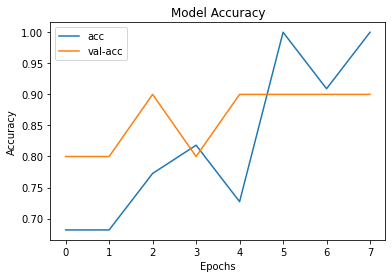

In [71]:
print(model_history.history.keys())
plt.plot(model_history.history['accuracy'],label='acc')
plt.plot(model_history.history['val_accuracy'],label='val-acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

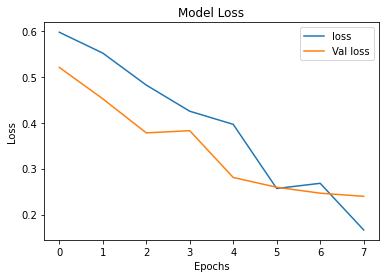

In [72]:
plt.plot(model_history.history['loss'],label='loss')
plt.plot(model_history.history['val_loss'],label='Val loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [74]:
from keras.preprocessing import image
path="/content/drive/MyDrive/Covid-Detection/Val/Normal/NORMAL2-IM-0652-0001.jpeg"
img=image.load_img(path,target_size=(256,256))
img=image.img_to_array(img)/225
img=np.array([img])
img.shape

(1, 256, 256, 3)

In [75]:
model.predict_classes(img)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1]], dtype=int32)

In [77]:
import os
y_actual,y_test=[],[]
for i in os.listdir("/content/drive/MyDrive/Covid-Detection/Val/Normal"):
    img=image.load_img("/content/drive/MyDrive/Covid-Detection/Val/Normal/"+i,target_size=(256,256))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    pred=model.predict_classes(img)
    y_test.append(pred[0,0])
    y_actual.append(1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [79]:
for i in os.listdir("/content/drive/MyDrive/Covid-Detection/Val/Covid"):
    img=image.load_img("/content/drive/MyDrive/Covid-Detection/Val/Covid/"+i,target_size=(256,256))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    pred=model.predict_classes(img)
    y_test.append(pred[0,0])
    y_actual.append(0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [80]:
y_actual=np.array(y_actual)
y_test=np.array(y_test)

In [81]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import seaborn as sns
cn=confusion_matrix(y_actual,y_test)
print(cn)


[[28  2]
 [ 2 28]]


In [82]:
ac=accuracy_score(y_actual,y_test)
print(ac)

0.9333333333333333


In [84]:
cr=classification_report(y_actual,y_test)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        30
           1       0.93      0.93      0.93        30

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60



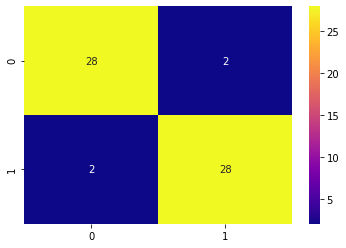

In [85]:
sns.heatmap(cn,cmap="plasma",annot=True) #0: Covid ; 1: Normal